### Part A

In [64]:
# HERE YOU WILL WRITE CODE TO TEST A NUMBER OF PREDICTORS
# AND FINALLY CHOOSE AND TRAIN THE PREDICTOR THAT YOU WILL BE USING FOR PART B
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
import lightgbm as lgbm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [65]:
dataP3 = pd.read_csv("CE802_P3_Data.csv")
dataP3.describe()

,F1,F2,F4,F5,F6,F7,F8,F9,F10,F12,...,F28,F29,F30,F31,F32,F33,F34,F35,F36,Target
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,201.687000,17.810507,-20.564893,2247.171820,0.570120,-24564.756680,80.580133,771.265033,9.012940,14.711640,...,1718.007973,313.425980,-6011.743960,3.831493,-34.436927,193.956653,-167.883327,575.845760,3.977333,856.493547
std,60.705946,86.571331,5.969597,1268.631888,82.215588,8895.299106,58.652866,307.203870,4.158463,8.429871,...,587.903119,89.687119,1299.793173,2.673263,42.300767,60.053084,41.185646,297.557767,1.755812,1222.860406
min,11.080000,-398.740000,-38.080000,-4686.990000,-382.300000,-55304.730000,-109.660000,-144.700000,-15.570000,-20.480000,...,-135.340000,20.250000,-12701.850000,0.030000,-289.920000,-15.940000,-361.180000,-483.430000,0.000000,-2685.920000
25%,159.105000,-24.800000,-24.705000,1631.722500,-40.635000,-30709.807500,41.995000,563.642500,6.830000,10.710000,...,1346.575000,253.642500,-6657.345000,1.870000,-55.747500,152.240000,-188.155000,373.057500,3.000000,17.235000
50%,202.830000,19.110000,-20.510000,2266.380000,0.050000,-24323.145000,79.340000,777.465000,9.120000,14.660000,...,1703.680000,312.030000,-6038.910000,3.265000,-34.815000,193.360000,-167.495000,581.515000,4.000000,624.735000
75%,240.620000,63.380000,-16.715000,2863.402500,42.350000,-18563.250000,121.805000,980.357500,11.250000,18.920000,...,2108.265000,373.110000,-5348.430000,5.100000,-13.832500,233.905000,-145.720000,776.852500,5.000000,1609.167500
max,425.520000,381.460000,1.920000,9854.070000,348.000000,8684.250000,270.040000,1630.790000,27.040000,51.540000,...,3909.840000,639.030000,119.100000,18.060000,192.270000,401.260000,31.570000,1537.170000,11.000000,3836.440000


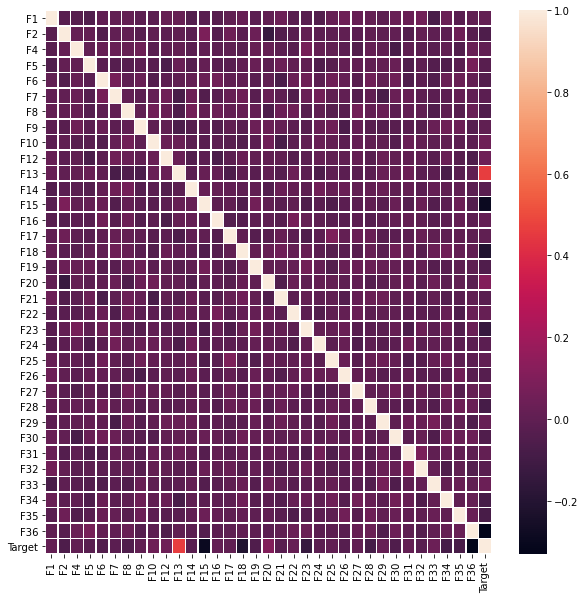

In [66]:
# describing the correlation of features 
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(dataP3.corr(), linewidths=.5, ax=ax)
plt.show()

### checking null values for a dataframe

In [67]:
def check_null_values(data):
    r = 0
    for col in data.columns:
        if data[col].isnull().any():
            r = 1
            print('Attribute "{}" has {} null'.format(col, data[col].isnull().sum()))
    return bool(r)
check_null_values(dataP3)

False

In [68]:
print(dataP3.F3.unique())
print(dataP3.F11.unique())
# Handling Nominal variables
enc = pd.get_dummies(dataP3.F11)
dataP3 = dataP3.join(enc)
dataP3.drop("F11", axis = 1, inplace = True)
one_hot_enc = pd.get_dummies(dataP3.F3) # one hot encoding
dataP3 = dataP3.join(one_hot_enc)
dataP3.drop("F3", axis=1, inplace = True)

['UK' 'USA' 'Europe' 'Rest']
['Very low' 'Medium' 'Low' 'Very high' 'High']


### seperating target attribute from other data

In [69]:
def target_split(data):
    X = data.loc[:, data.columns != "Target"].to_numpy()
    y = data.loc[:, data.columns == "Target"].to_numpy()
    return X, y
X, y = target_split(dataP3)
X.shape

(1500, 43)

### applying quantile transformer on the data and then 


### train linear regression model, and evaluate it using K-fold 

In [70]:
def linear_regression_fit(data):
    X, y = target_split(data)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
    out_results_score = []
    out_results_rmse = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LinearRegression()
        ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
        ttr.fit(X_train, y_train)
        score = ttr.score(X_test, y_test)
        out_results_score.append(score)
        y_pred = ttr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred,squared = False)
        out_results_rmse.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        print("> Score : %.3f, MAE: %.3f, RMSE: %.3f "% (score, mae, rmse))
    print("Average-Score: %.3f, Average-RMSE: %.3f, Score-Std: %.3f, RMSE-Std: %.3f"%(np.mean(out_results_score), np.mean(out_results_rmse), np.std(out_results_score), np.std(out_results_rmse)))
    return ttr, round(score,3), round(rmse,3)

### doing the same on random forest, ridge, LGBM and decision tree regressor model

In [71]:
def random_forest_fit(data):
    X, y = target_split(data)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
    out_results_score = []
    out_results_rmse = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        random_forest = RandomForestRegressor(max_depth = 7)
        ttr = TransformedTargetRegressor(regressor=random_forest, transformer=QuantileTransformer(output_distribution='normal'))
        ttr.fit(X_train, y_train)
        score = ttr.score(X_test, y_test)
        out_results_score.append(score)
        y_pred = ttr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred,squared = False)
        out_results_rmse.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        print("> Score : %.3f, MAE: %.3f, RMSE: %.3f "% (score, mae, rmse))
    print("Average-Score: %.3f, Average-RMSE: %.3f, Score-Std: %.3f, RMSE-Std: %.3f"%(np.mean(out_results_score), np.mean(out_results_rmse), np.std(out_results_score), np.std(out_results_rmse)))
    return ttr, round(score,3), round(rmse,3)

In [72]:
def ridge_fit(data):
    X, y = target_split(data)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
    out_results_score = []
    out_results_rmse = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge_reg = Ridge()
        ttr = TransformedTargetRegressor(regressor=ridge_reg, transformer=QuantileTransformer(output_distribution='normal'))
        ttr.fit(X_train, y_train)
        score = ttr.score(X_test, y_test)
        out_results_score.append(score)
        y_pred = ttr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred,squared = False)
        out_results_rmse.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        print("> Score : %.3f, MAE: %.3f, RMSE: %.3f "% (score, mae, rmse))
    print("Average-Score: %.3f, Average-RMSE: %.3f, Score-Std: %.3f, RMSE-Std: %.3f"%(np.mean(out_results_score), np.mean(out_results_rmse), np.std(out_results_score), np.std(out_results_rmse)))
    return ttr, round(score,3), round(rmse,3)

In [73]:
def LGBM_regression_fit(data):
    X, y = target_split(data)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
    out_results_score = []
    out_results_rmse = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lgbm_reg = lgbm.LGBMRegressor()
        ttr = TransformedTargetRegressor(regressor=lgbm_reg, transformer=QuantileTransformer(output_distribution='normal'))
        ttr.fit(X_train, y_train)
        score = ttr.score(X_test, y_test)
        out_results_score.append(score)
        y_pred = ttr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred,squared = False)
        out_results_rmse.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        print("> Score : %.3f, MAE: %.3f, RMSE: %.3f "% (score, mae, rmse))
    print("Average-Score: %.3f, Average-RMSE: %.3f, Score-Std: %.3f, RMSE-Std: %.3f"%(np.mean(out_results_score), np.mean(out_results_rmse), np.std(out_results_score), np.std(out_results_rmse)))
    return ttr, round(score,3), round(rmse,3)

### running the defined functions in previous cells

In [74]:
ridge, score, rmse = ridge_fit(dataP3)

> Score : 0.700, MAE: 518.523, RMSE: 676.115 
> Score : 0.698, MAE: 501.994, RMSE: 663.459 
> Score : 0.723, MAE: 534.853, RMSE: 645.338 
> Score : 0.644, MAE: 523.764, RMSE: 699.769 
> Score : 0.611, MAE: 575.748, RMSE: 736.354 
> Score : 0.642, MAE: 556.711, RMSE: 721.078 
> Score : 0.761, MAE: 525.439, RMSE: 665.684 
> Score : 0.776, MAE: 443.786, RMSE: 574.433 
> Score : 0.686, MAE: 489.418, RMSE: 635.153 
> Score : 0.703, MAE: 503.291, RMSE: 661.248 
Average-Score: 0.694, Average-RMSE: 667.863, Score-Std: 0.049, RMSE-Std: 43.570


In [75]:
lr, score, rmse = linear_regression_fit(dataP3)

> Score : 0.701, MAE: 518.321, RMSE: 675.881 
> Score : 0.698, MAE: 501.996, RMSE: 663.176 
> Score : 0.723, MAE: 534.832, RMSE: 645.475 
> Score : 0.644, MAE: 523.724, RMSE: 699.899 
> Score : 0.610, MAE: 576.261, RMSE: 736.826 
> Score : 0.642, MAE: 556.928, RMSE: 721.066 
> Score : 0.761, MAE: 525.137, RMSE: 665.270 
> Score : 0.777, MAE: 443.893, RMSE: 574.314 
> Score : 0.686, MAE: 489.516, RMSE: 635.307 
> Score : 0.703, MAE: 503.422, RMSE: 661.385 
Average-Score: 0.694, Average-RMSE: 667.860, Score-Std: 0.050, RMSE-Std: 43.658


In [76]:
LGBM, score, rmse = LGBM_regression_fit(dataP3)

> Score : 0.876, MAE: 296.539, RMSE: 435.534 
> Score : 0.889, MAE: 298.505, RMSE: 401.917 
> Score : 0.871, MAE: 311.358, RMSE: 439.802 
> Score : 0.848, MAE: 347.722, RMSE: 456.897 
> Score : 0.852, MAE: 330.865, RMSE: 454.059 
> Score : 0.844, MAE: 328.175, RMSE: 475.656 
> Score : 0.862, MAE: 360.517, RMSE: 505.679 
> Score : 0.870, MAE: 308.543, RMSE: 438.270 
> Score : 0.895, MAE: 273.942, RMSE: 368.032 
> Score : 0.894, MAE: 270.467, RMSE: 394.677 
Average-Score: 0.870, Average-RMSE: 437.052, Score-Std: 0.018, RMSE-Std: 38.325


In [77]:
randomForest, score, rmse = random_forest_fit(dataP3)

> Score : 0.630, MAE: 553.332, RMSE: 751.458 
> Score : 0.663, MAE: 509.948, RMSE: 699.999 
> Score : 0.652, MAE: 531.774, RMSE: 723.499 
> Score : 0.661, MAE: 507.243, RMSE: 682.363 
> Score : 0.610, MAE: 576.650, RMSE: 737.499 
> Score : 0.620, MAE: 552.704, RMSE: 742.266 
> Score : 0.611, MAE: 604.173, RMSE: 849.106 
> Score : 0.664, MAE: 517.124, RMSE: 704.340 
> Score : 0.678, MAE: 496.134, RMSE: 642.764 
> Score : 0.714, MAE: 489.483, RMSE: 648.839 
Average-Score: 0.650, Average-RMSE: 718.213, Score-Std: 0.031, RMSE-Std: 56.153


### Part B

In [78]:
# HERE YOU WILL USE THIS TEMPLATE TO SAVE THE PREDICTIONS ON THE TEST SET

# Load the test data
test_df = pd.read_csv('CE802_P3_Test.csv')

# Make sure you work on a copy
test_data = test_df.iloc[:,:-1].copy()

enc = pd.get_dummies(test_data.F3)
test_data = test_data.join(enc)
test_data.drop("F3", axis = 1, inplace = True)

enc = pd.get_dummies(test_data.F11)
test_data = test_data.join(enc)
test_data.drop("F11", axis = 1, inplace = True)

predicted = LGBM.predict(test_data)

# Replace the last (empty) column with your prediction
test_df.iloc[:,-1] = predicted

# Save to the destination file
test_df.to_csv('CE802_P3_Test_Predictions.csv', index=False, float_format='%.8g')

# IMPORTANT!! Make sure only the last column has changed
assert pd.read_csv('CE802_P3_Test.csv').iloc[:,:-1].equals(pd.read_csv('CE802_P3_Test_Predictions.csv').iloc[:,:-1])